In [4]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from utilities import train_test_val_split, load_matlab_data, rmse
from scipy.io import savemat
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
from scipy.stats import norm

In [5]:
x, y = load_matlab_data("data/hwkdataNEW.mat")
xtr, ytr, xts, yts, xv, yv = train_test_val_split(x, y, seed=3)

In [24]:
class LocalWeightedRegression():
    def __init__(self, kernel='gaussian', distance='l2', bandwidth=0.25):
        self.xscaler = None
        self.yscaler = None
        self.xs_vec = None
        self.ys_vec = None
        self.bandwidth = bandwidth
        
        distances = {
            'l2': self.l2,
            'euclidean': self.l2,
        }
        kernels = {
            'gaussian': norm.pdf,
            'pyramid': np.vectorize(self.pyramid_kernel),
            'boxcar': np.vectorize(self.boxcar_kernel)
        }
        
        self.kernel = kernels[kernel]
        self.distance = distances[distance]
    
    def fit(self, x, y):
        self.xscaler = StandardScaler().fit(x)
        self.yscaler = StandardScaler().fit(y)
        xs = self.xscaler.transform(x)
        ys = self.yscaler.transform(y)
        self.xs_vec = xs
        self.ys_vec = ys
    
    def predict(self, x):
        xs = self.xscaler.transform(x)
        
        # Calculate distance for every point
        d = cdist(self.xs_vec, xs)
        
        # Calculate the weight for every point
        w = self.kernel(d, self.bandwidth)
        
        ypu = [self.lin(xs[i], w[:,i]) for i in range(xs.shape[0])]
        
        yp = self.yscaler.inverse_transform(ypu)
        
        return yp
    
    def lin(self, x, w):
        l = LinearRegression()
        l.fit(self.xs_vec, self.ys_vec, sample_weight=w)
        return l.predict(x.reshape(1, -1))
    
    # Distance measures
    def l2(self, x):
        return cdist(self.xs_vec, x)
    
    # Kernels
    def gaussian_kernel(self, d, bw):
        return norm.pdf(d, scale=bw)
    
    def pyramid_kernel(self, d, bw):
        c = 1 / (2 - 1/bw)
        if d > bw:
            return 0.
        else:
            return c * (1. - d / bw)
    
    def boxcar_kernel(self, d, bw):
        if d > bw:
            return 0.
        else:
            return 1.

In [25]:
lwr = LocalWeightedRegression()

In [26]:
l = 100
x = (np.linspace(0, 10, l) + np.random.randn(l))
y = (10 * np.sin(x) + 3 * x + np.random.randn(l))
print(y.shape)

(100,)


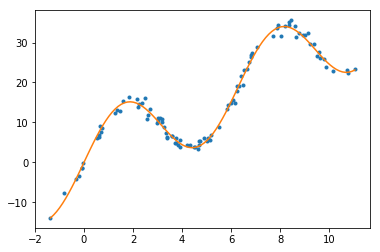

In [27]:
xc = np.linspace(np.min(x), np.max(x), l)
plt.plot(x, y, '.')
plt.plot(xc, 10 * np.sin(xc) + 3 * xc)

In [28]:
lwr.fit(x.reshape(-1, 1), y.reshape(-1, 1))

In [30]:
lwr.predict([[8]])

array([[[ 24.69061205]]])